## The price is right problem

Contestants have to guess the price of some prizes and need to get close without going over. There are two contestants guessing the price of 2 showcases.

1. What prior beliefs should contestant have before seeing prizes?
2. After seeing the prizes how should they update their beliefs?
3. Based on the posterior distribution, what should they bid?

3rd questions is an example of decision analysis, maximising expected return.

To chose our prior, we can use data from previous shows. 

In [3]:
import csv
import numpy
import thinkbayes
# import thinkplot

import matplotlib.pyplot as pyplot


FORMATS = ['png', 'pdf', 'eps']


def ReadData(filename='showcases.2011.csv'):
    """Reads a CSV file of data.
    Args:
      filename: string filename
    Returns: sequence of (price1 price2 bid1 bid2 diff1 diff2) tuples
    """
    fp = open(filename)
    reader = csv.reader(fp)
    res = []

    for t in reader:
        _heading = t[0]
        data = t[1:]
        try:
            data = [int(x) for x in data]
            # print(heading, data[0], len(data))
            res.append(data)
        except ValueError:
            pass

    fp.close()
    return list(zip(*res))


data = ReadData()

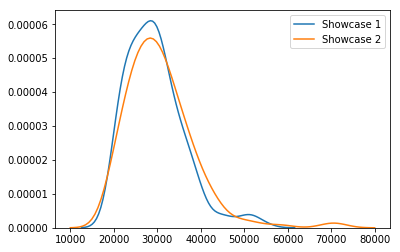

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(numpy.array(data)[:,0], label='Showcase 1')
sns.kdeplot(numpy.array(data)[:,1],  label='Showcase 2')
plt.legend()
plt.show()

## Probability density functions

We have mainly been working with probability mass functions, which map from each possible value to its probability.

PDFs are written as functions, where the integral over a given range gives the probability that the observed result is in the given range.

The PDF of a Gaussian with mean 0 and std 1 is written:

f(x) = 1/sqrt(2pi)exp(-x^2/2)

Values of PDFs are not bounded between 0 and 1 like a probability, can be 0 or any +ve number.

PDFs can be used as part of likelihood functions.


In [14]:
## Pdf class is an abstract type

import scipy

class Pdf(object):
    
    def Density(self, x):
        raise UnimplementedMethodException()
        
    def MakePmf(self,xs):
        pmf = Pmf()
        for x in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf
    
## Density needs to be provided by child class, this is a concrete type as it extends an abstract type

class GaussianPdf():

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def Density(self, x):
        ## uses norm.pdf from scipy
        return scipy.stats.norm.pdf(x, self.mu, self.sigma)

Above, we are assuming the distribution is Gaussian. But often case that there is no simple distribution that fits the data.

In this case we can use a sample to estimate the PDF of the full population.

When using a sample, we assume that the PDF is fairly smooth (even if we have gaps in datapoints from sample).

Kernel density estimation takes a sample and approximates a smooth PDF to fit the data.

In [27]:
# class EstimatedPdf(Pdf):
    
#     def __init__(self, sample):
#         self.kde = scipy.stats.gaussian_kde(sample)
        
#     def Density(self, x):
#         return self.kde.evaluate(x)
    
# prices = ReadData()
# pdf = thinkbayes.EstimatedPdf(prices)

# low, high = 0, 75000
# n = 101
# xs = numpy.linspace(low, high, n)
# pmf = pdf.MakePmf(xs)

## Modelling the contestants

Contestants could use the PDF of possible prices as a prior belief before the showcase.

To update these priors, need to decide what data should be considered, how it's quantified and how the likelihood function can be computed (for each hypothetical value of the price can we compute the conditional likelihood of the data)?

Can model contestant as price-guessing instrument with known error characteristics. Guess the price of each item and add them up to get their 'guess'.

We can ask: if the actual price is 'price' what is the likelihood that the contestant's estimate would be 'guess'?

error = price - guess, what is the likelihood that contestants estimate is off by 'error'?

We can use historical data again, looking at the cummulative distribution of diff. 

When diff is negitive, the bid is too high. Data shows a trend of contestants under guessing.

We can estimate participants guesses from their bid. Assume distribution of error is gaussian with mean 0 and same variance as diff.

## Likelihood

Doesn't need to calculate the probability, just something proportional to a probability. So, it's okay to use the probability density rather than a probability here as the constant of proportionality is the same for all likelihoods so gets cancelled out when we normalise the posterior.

So PDFs are fine to be used as likelihood.

## Update

PmfPrice gives a discrete approximation of the PDF of price which can be used for prior.

Posterior is constructed by copying the prior and involking Update, which involkes Likelihood for each hypo, multiplies piors by likelihoods then normalises.

This problem shows to usefulness of having a posterior distribution that allows us to make optimal decisions afterwards, which wouldn't be easy to do with point estimates.

In [30]:
class Price(thinkbayes.Suite):
    def __init__(self, pmf, player):
        thinkbayes.Suite.__init__(self, pmf)
        self.player = player
        
    def Likelihood(self, data, hypo):
        price = hypo
        guess = data
        
        error = price - guess
        like = self.player.ErrorDensity(error)
        
        return like
    
## class Player:

def ErrorDensity(self, error):
    return self.pdf_error.Density(error)


def MakeBeliefs(self, guess):
    pmf = self.PmfPrice()
    self.prior = Price(pmf, self)
    self.posterior = self.prior.Copy()
    self.posterior.Update(guess)
    
n = 101
price_xs = numpy.linspace(0,75000,n)

def PmfPrice(self):
    return self.pdf_price.MakePmf(self.price_xs)

## Optimal guessing

Once we have a posterior distribution, we can use it to maximise the return in order to decide what the optimal bid is.

An overview of the steps taken to do this:



In [ ]:
class GainCalculator(object):
    def __init__(self, player, opponent):
        self.player = player
        self.opponent = opponent
        
## player and opponent are Player() objects

    def ExpectedGains(self, low=0, high=75000, n=101):
        bid = numpy.linspace(low, high, n)
        gains = [self.ExpectedGain(bid) for bid in bids]
        
        return bids, gains
    
    
    def ExpectedGain(self, bid):
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()):
            gain = self.Gain(bid, price)
            total += prob * gain
        return total
    
    ## Loops through values in posterior and computes gains given the actual prices
    
    def Gain(self, big, price):
        if bid > price:
            return 0
        
        diff = price - bid
        prob = self.ProbWin(diff)
        
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob
        
    ## Works out the prob of winning and multiplies by price to find gain. Note when diff <= 250 they win the opponents prize as well
    ## which is approx same price, hence the multiplication by 2
        
    def ProbWin(self, diff):
        prob = (self.opponent.ProbOverbid() + self.opponent.ProbWorseThan(diff))
        return prob
    
    ## The probability of winning based on diff
    
## class Player

def ProbOverbid(self):
    return self.cdf_diff.Prob(-1)

def ProbWorseThan(self, diff):
    return 1 - self.cdf_diff.Prob(diff)

## These two functions are called from the opponents point of view, to see the probability that they overbid or the probability that 
## their guess is off by more than 'diff'

def OptimalBid(self, guess, opponent):
    self.MakeBeliefs(guess)
    calc = GainCalculator(self, opponent)
    bids, gains = calc.ExpectedGains()
    gain, bid = max(zip(gains, bids))
    return bid, gain

## Optimal bid computes a posterior for a given guess and opponent, computes the potential gains for a range of bids and finds the 
## optimal bid (and gain associated with this)

